In [1]:
import os
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from nfstream import NFStreamer
import statsmodels.api as sm

%matplotlib inline

plt.rcParams.update({
    'font.size': 16,
    'figure.figsize': [12, 8]
})

%config Completer.use_jedi = False

In [2]:
protocol_lookup = pd.read_csv("../data/protocol-numbers-1.csv")[["Decimal", "Keyword"]].set_index("Decimal").to_dict()["Keyword"]
mac_mapping = json.load(open("../data/device_mac.json"))
ad_list = pd.read_csv('../data/hosts', comment='#', delimiter=' ', error_bad_lines=False, warn_bad_lines=False)

In [3]:
root_dir = "../data"
nrows=None

In [4]:
files = glob(os.path.join(root_dir, "*.csv.gz"))

all_dfs = []
for csv_file in tqdm(files, total=len(files)):
    all_dfs.append(pd.read_csv(csv_file, nrows=nrows))
    
all_df = pd.concat(all_dfs).sort_values("bidirectional_first_seen_ms").reset_index(drop=1)

100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


In [5]:
all_df['date'] = all_df.bidirectional_first_seen_ms.apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(x/1000.0))
).apply(pd.Timestamp)

all_df["protocol_name"] = all_df.protocol.apply(lambda x: protocol_lookup[str(x)] if str(x) in protocol_lookup else "Unassigned")

In [6]:
all_df["device"] = all_df.src_mac.apply(lambda x: mac_mapping[str(x).lower()] if str(x).lower() in mac_mapping else "Unassigned")

In [7]:
all_df.device.value_counts()

enis-macbook      478857
ece-samsung       182909
enis-iphone       178506
ece-macbook       116438
ece-windows       109366
omer-macbook       41039
Unassigned         36092
omer-iphone        27442
enis-tablet         9383
omer-ipad           2455
enis-switch          834
enis-projector       158
enis-watch           114
Name: device, dtype: int64

In [8]:
def get_locale_timezone(row):
    if row["whoami"] == "ece":
        return row['date'].tz_localize("UTC").tz_convert('Europe/Berlin')
    return row['date'].tz_localize("UTC").tz_convert('Europe/Istanbul')

all_df["date_locale"] = all_df.apply(get_locale_timezone, axis=1)

In [9]:
def is_idle(t):
    if t.hour in [3, 4, 5, 6, 12]: # We could not log the idle and active times :( night and lunch break
        return True
    return False

all_df["is_idle"] = all_df.date_locale.apply(is_idle)

In [10]:
def is_encrypted(row):
    if row["dst_port"] == 443:
        return True
    if "TLS" in row["application_name"]:
        return True
    if "SSH" in row["application_name"]:
        return True
    if "SSL" in row["application_name"]:
        return True
    return False

all_df["is_encrypted"] = all_df.apply(is_encrypted, axis=1)

In [11]:
l = ad_list.website.values

In [12]:
ad_list = []
for i, r in tqdm(all_df.iterrows(), total=len(all_df)):
    ad_list.append(r["requested_server_name"] in l    )

100%|██████████| 1183593/1183593 [30:44<00:00, 641.81it/s]


In [13]:
all_df["is_ad"] = ad_list

## Day Night Aggreagation

In [14]:
def is_night(t):
    if t.hour in [24, 0, 1, 2, 3, 4, 5]:
        return True
    return False

all_df["is_night"] = all_df.date_locale.apply(is_night)

### Protocol Name

In [15]:
temp_df = all_df.groupby(["is_night", "protocol_name"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [16]:
u_protocol_names = temp_df.protocol_name.unique()

temp_df_day = temp_df[~temp_df.is_night].copy()
temp_df_night = temp_df[temp_df.is_night].copy()

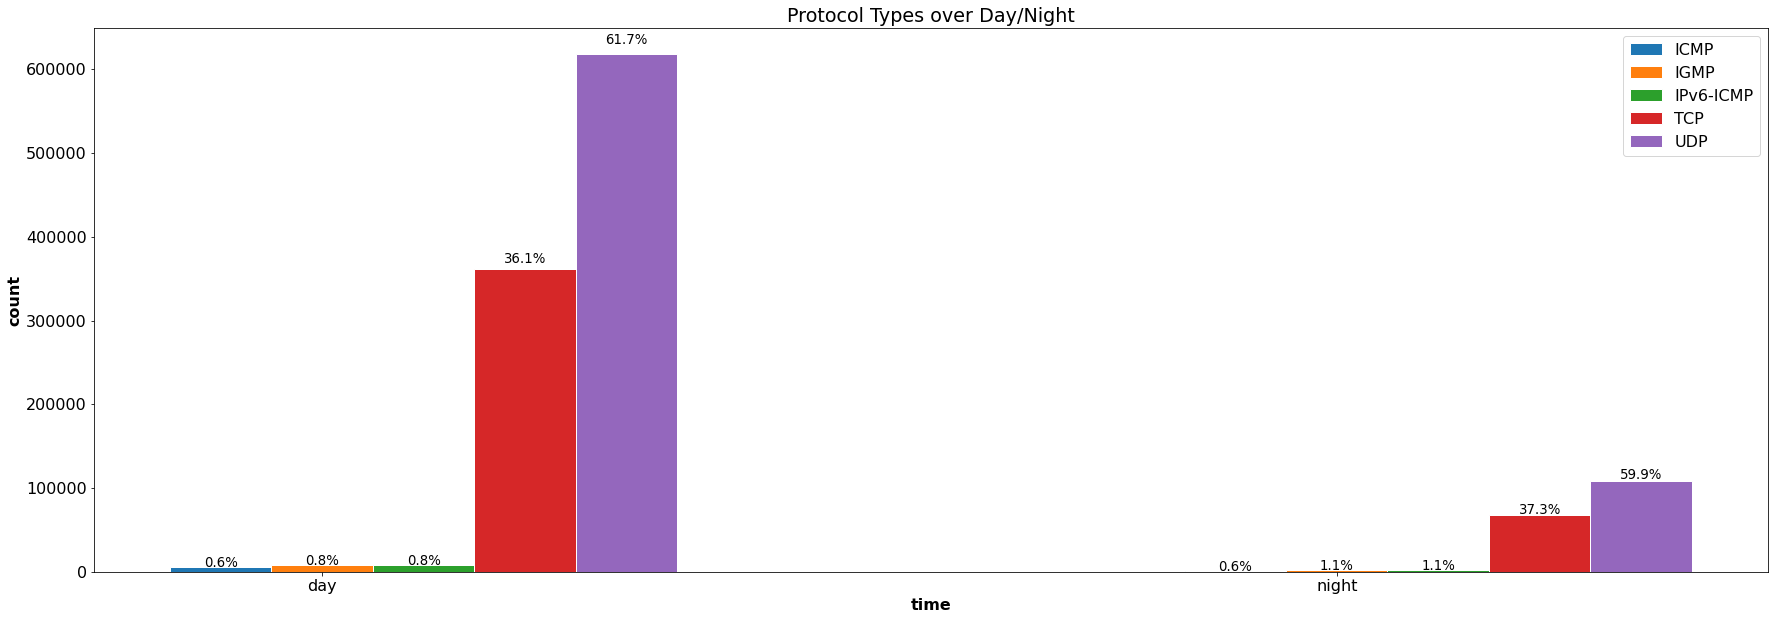

In [17]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.10
 
bars = []
for p in u_protocol_names:
    d = temp_df_day[temp_df_day.protocol_name == p]
    n = temp_df_night[temp_df_night.protocol_name == p]
    bars.append([
        d.iloc[0]["count"] if len(d) else 0,
        n.iloc[0]["count"] if len(n) else 0
    ])

    

rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

    
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)

sums = list(np.array(bars).sum(axis=0))

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    ax.bar(r, bar, width=barWidth, edgecolor='white', label=v)
    for i, p in enumerate(ax.patches[-len(r):]):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate("{:.1f}%".format(float(height*100/sums[i])), (x + width/2, y + height*1.02), ha='center', fontsize='small')
    
    

    
plt.title("Protocol Types over Day/Night")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], ["day", "night"])
 
# # Create legend & Show graphic
plt.legend()
plt.show()

### DNS Requests

In [18]:
temp_df = all_df[all_df.dst_port == 53].copy() # DNS port
temp_df = all_df.groupby(["is_night"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]

In [19]:
temp_df[~temp_df.is_night].iloc[0]["count"], temp_df[temp_df.is_night].iloc[0]["count"]

(1001846, 181747)

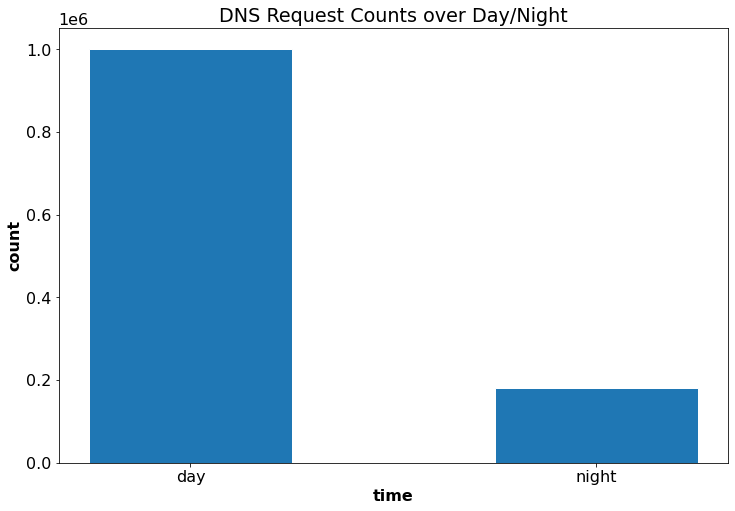

In [20]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.5
 
plt.bar([0, 1], [
    temp_df[~temp_df.is_night].iloc[0]["count"], temp_df[temp_df.is_night].iloc[0]["count"]
], width=barWidth, edgecolor='white')

plt.title("DNS Request Counts over Day/Night")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r for r in range(2)], ["day", "night"])
 
# Create legend & Show graphic
plt.show()


### Encryption

In [21]:
temp_df = all_df.groupby(["is_night", "is_encrypted"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [22]:
u_protocol_names = ["encrypted", "not_encrypted"]

temp_df_day = temp_df[~temp_df.is_night].copy()
temp_df_night = temp_df[temp_df.is_night].copy()

In [23]:
temp_df

,is_night,is_encrypted,count
0,False,False,653747
1,False,True,348099
2,True,False,115341
3,True,True,66406


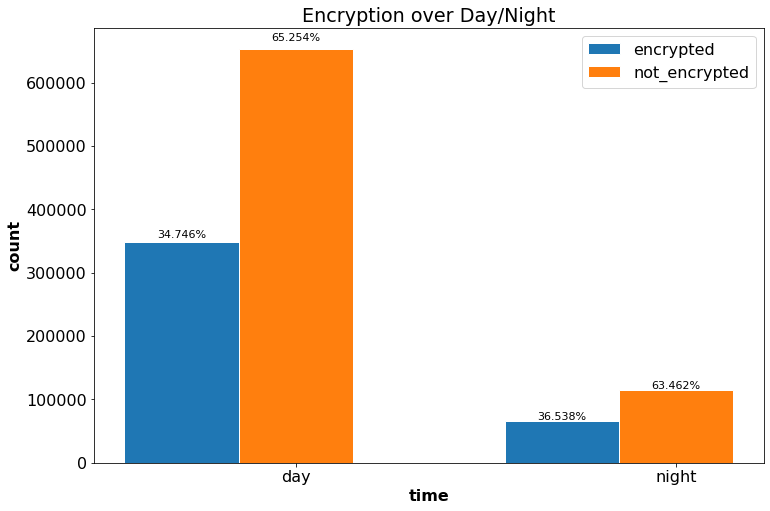

In [24]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.30
 
bars = []
for p in u_protocol_names:
    if p == "encrypted":
        d = temp_df_day[temp_df_day.is_encrypted]
        n = temp_df_night[temp_df_night.is_encrypted]
    else:
        d = temp_df_day[~temp_df_day.is_encrypted]
        n = temp_df_night[~temp_df_night.is_encrypted]
    bars.append([
        d.iloc[0]["count"] if len(d) else 0,
        n.iloc[0]["count"] if len(n) else 0
    ])
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

fig, ax = plt.subplots()

sums = list(np.array(bars).sum(axis=0))

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    ax.bar(r, bar, width=barWidth, edgecolor='white', label=v)
    for i, p in enumerate(ax.patches[-len(r):]):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate("{:.3f}%".format(float(height*100/sums[i])), (x + width/2, y + height*1.02), ha='center', fontsize='x-small')
    
plt.title("Encryption over Day/Night")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], ["day", "night"])
 
# # Create legend & Show graphic
plt.legend()
plt.show()


## Device Type Aggreagations

In [25]:
def get_device_type(d):
    if "iphone" in d:
        return "phone"
    if "samsung" in d:
        return "phone"
    if "projector" in d:
        return "IoT"
    if "switch" in d:
        return "IoT"
    if "watch" in d:
        return "IoT"
    if "macbook" in d:
        return "computer"
    if "windows" in d:
        return "computer"
    if "ipad" in d:
        return "tablet"
    if "tablet" in d:
        return "tablet"
    return "other"

all_df["device_type"] = all_df["device"].apply(get_device_type)
all_devices = all_df["device_type"].unique()

### Protocol Name

In [26]:
temp_df = all_df.groupby(["device_type", "protocol_name"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [27]:
u_protocol_names = temp_df.protocol_name.unique()

temp_dfs = [temp_df[temp_df.device_type == dt].copy() for dt in all_devices]

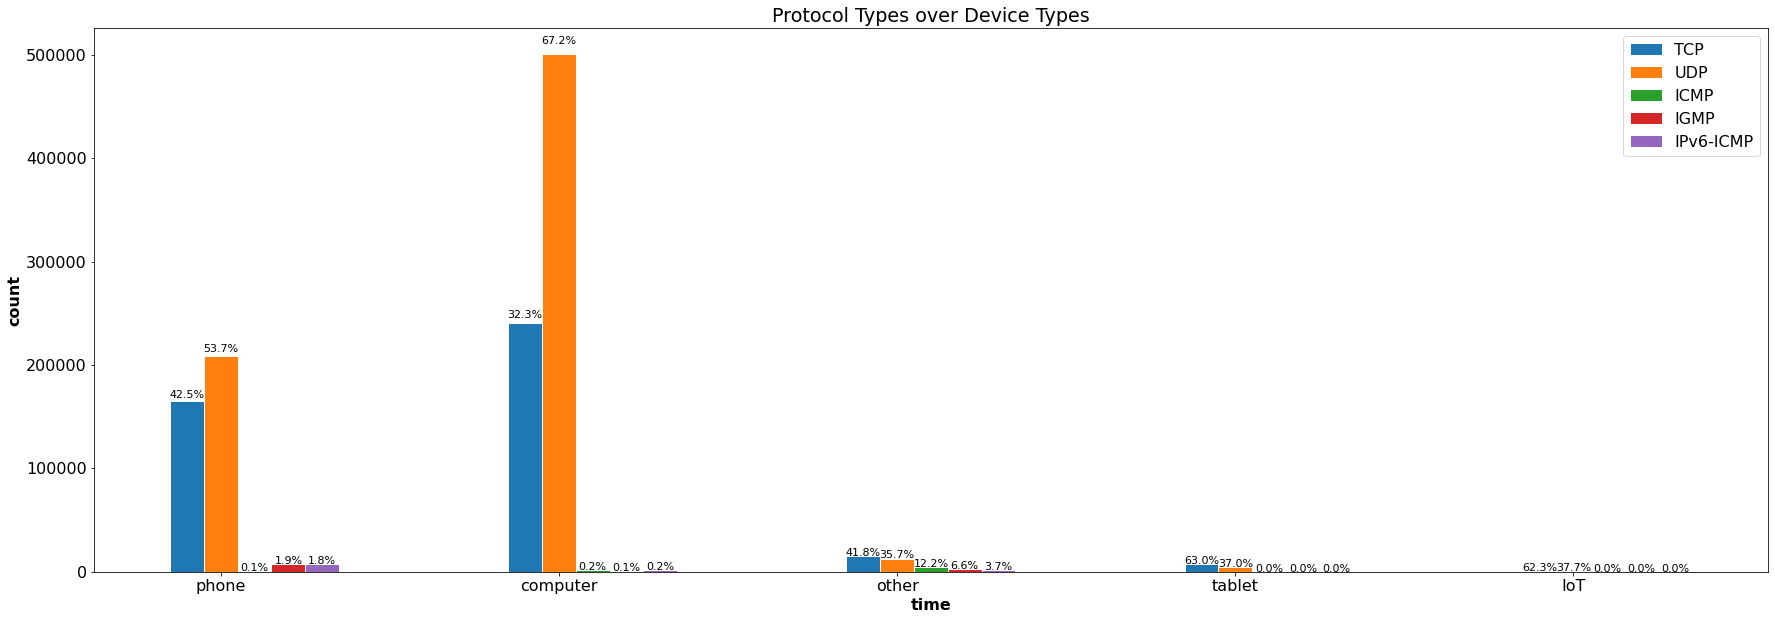

In [28]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.10
 
bars = []
for p in u_protocol_names:
    tl = []
    for t in temp_dfs: 
        d = t[t.protocol_name == p]
        tl.append(d.iloc[0]["count"] if len(d) else 0)
    bars.append(tl)
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)

sums = list(np.array(bars).sum(axis=0))

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    ax.bar(r, bar, width=barWidth, edgecolor='white', label=v)
    for i, p in enumerate(ax.patches[-len(r):]):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate("{:.1f}%".format(float(height*100/sums[i])), (x + width/2, y + height*1.02), ha='center', fontsize='x-small')

plt.title("Protocol Types over Device Types")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')

plt.xticks([r + barWidth for r in range(len(bars[1]))], all_devices)
 
# # Create legend & Show graphic
plt.legend()
plt.show()


### DNS Requests

In [29]:
temp_df = all_df[all_df.dst_port == 53].copy()
temp_df = all_df.groupby(["device_type"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.lo

In [30]:
ll = []

for dt in all_devices:
    d = temp_df[temp_df.device_type == dt]
    ll.append(d.iloc[0]["count"] if len(d) else 0)

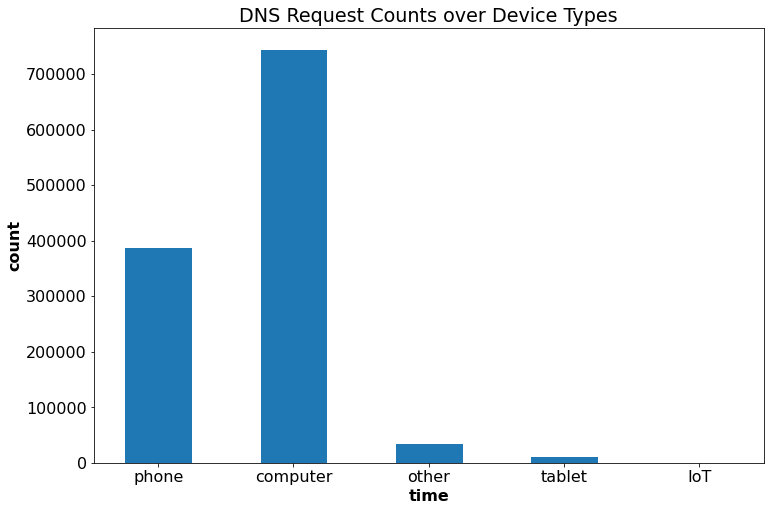

In [31]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.5
 
plt.bar(np.arange(len(all_devices)), ll, width=barWidth, edgecolor='white')

plt.title("DNS Request Counts over Device Types")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r for r in range(len(all_devices))], all_devices)
 
# Create legend & Show graphic
plt.show()


### Encryption

In [32]:
temp_df = all_df.groupby(["device_type", "is_encrypted"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [33]:
u_protocol_names = ["encrypted", "not_encrypted"]

temp_dfs = [temp_df[temp_df.device_type == dt].copy() for dt in all_devices]

In [34]:
temp_df

,device_type,is_encrypted,count
0,IoT,False,471
1,IoT,True,635
2,computer,False,511453
3,computer,True,234247
4,other,False,25744
5,other,True,10348
6,phone,False,225585
7,phone,True,163272
8,tablet,False,5835
9,tablet,True,6003


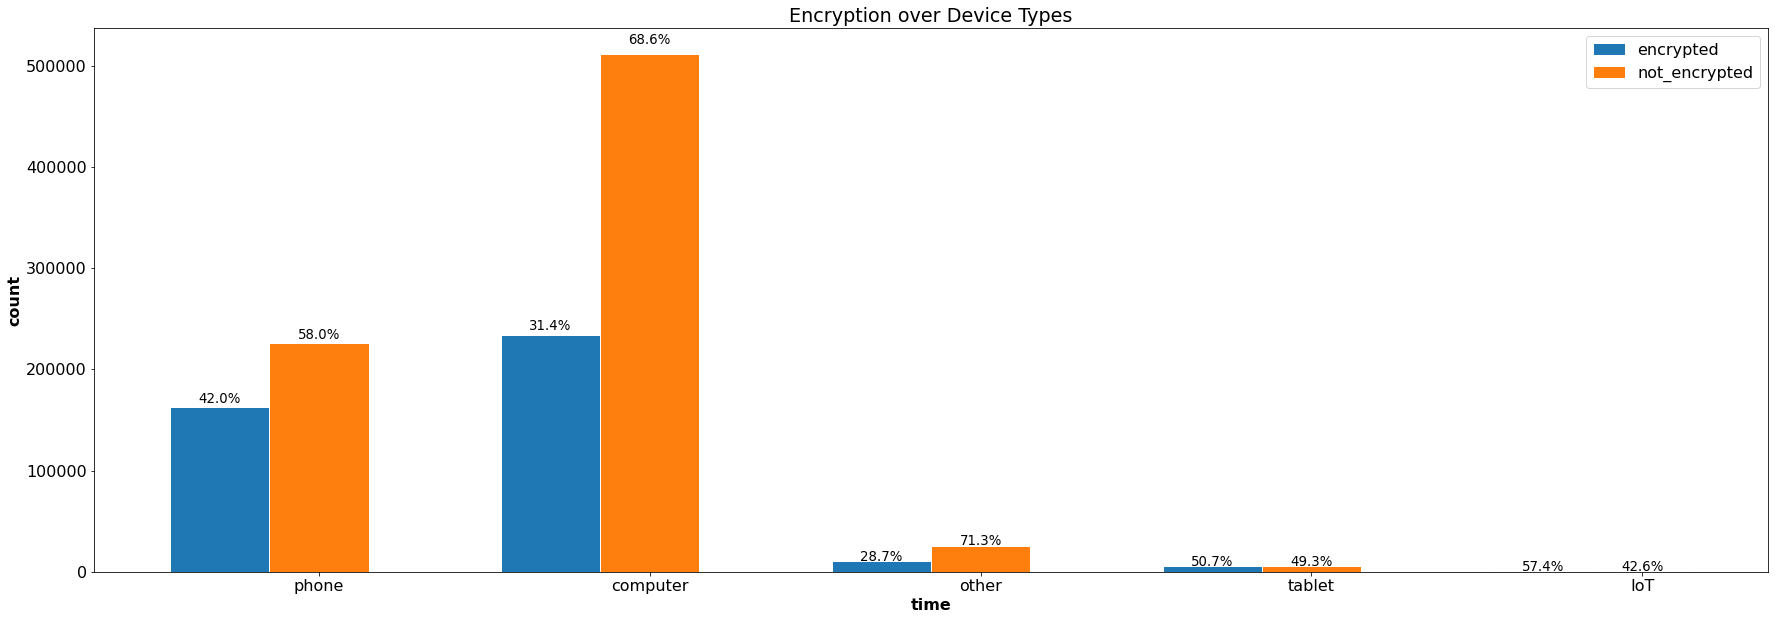

In [35]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.30
 
bars = []
for p in u_protocol_names:
    tl = []
    for t in temp_dfs:
        d = t[~t.is_encrypted]
        if p == "encrypted":
            d = t[t.is_encrypted]
        tl.append(d.iloc[0]["count"] if len(d) else 0)
    bars.append(tl)
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)

sums = list(np.array(bars).sum(axis=0))

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    ax.bar(r, bar, width=barWidth, edgecolor='white', label=v)
    for i, p in enumerate(ax.patches[-len(r):]):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate("{:.1f}%".format(float(height*100/sums[i])), (x + width/2, y + height*1.02), ha='center', fontsize='small')

plt.title("Encryption over Device Types")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], all_devices)
 
# # Create legend & Show graphic
plt.legend()
plt.show()


## Ecryption Aggreagation

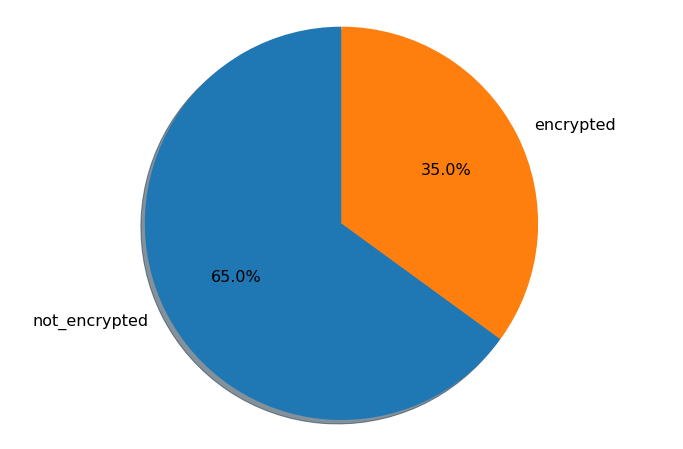

In [36]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'not_encrypted', 'encrypted'
sizes = [(~all_df["is_encrypted"]).sum(), all_df["is_encrypted"].sum()]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.savefig("piechart.png")

### Protocol Types

In [37]:
temp_df = all_df.groupby(["is_idle", "protocol_name"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [38]:
u_protocol_names = temp_df.protocol_name.unique()

temp_df_day = temp_df[~temp_df.is_idle].copy()
temp_df_night = temp_df[temp_df.is_idle].copy()

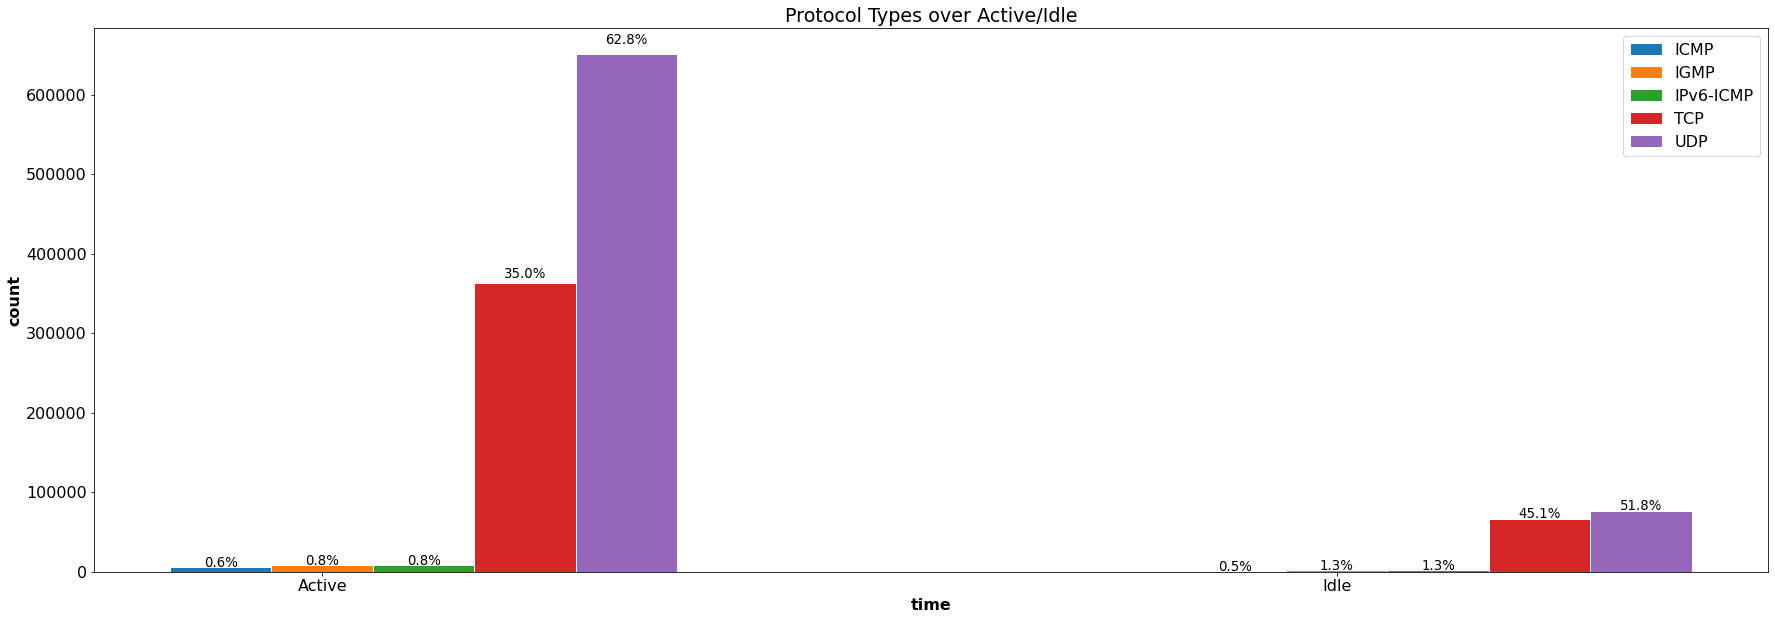

In [39]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.10
 
bars = []
for p in u_protocol_names:
    d = temp_df_day[temp_df_day.protocol_name == p]
    n = temp_df_night[temp_df_night.protocol_name == p]
    bars.append([
        d.iloc[0]["count"] if len(d) else 0,
        n.iloc[0]["count"] if len(n) else 0
    ])
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)

sums = list(np.array(bars).sum(axis=0))

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    ax.bar(r, bar, width=barWidth, edgecolor='white', label=v)
    for i, p in enumerate(ax.patches[-len(r):]):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate("{:.1f}%".format(float(height*100/sums[i])), (x + width/2, y + height*1.02), ha='center', fontsize='small')

plt.title("Protocol Types over Active/Idle")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], ["Active", "Idle"])
 
# # Create legend & Show graphic
plt.legend()
plt.show()


### DNS Requests

In [40]:
temp_df = all_df[all_df.dst_port == 53].copy()
temp_df = all_df.groupby(["is_idle"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]

In [41]:
temp_df[~temp_df.is_idle].iloc[0]["count"], temp_df[temp_df.is_idle].iloc[0]["count"]

(1036288, 147305)

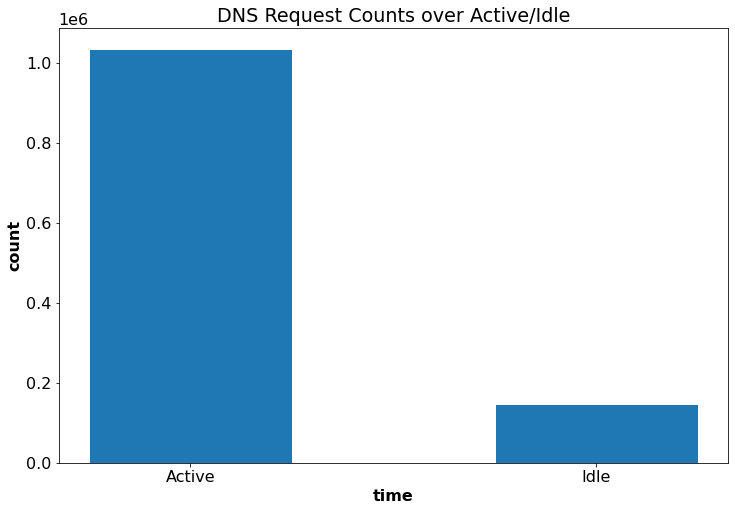

In [42]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.5
 
plt.bar([0, 1], [
    temp_df[~temp_df.is_idle].iloc[0]["count"], temp_df[temp_df.is_idle].iloc[0]["count"]
], width=barWidth, edgecolor='white')

plt.title("DNS Request Counts over Active/Idle")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r for r in range(2)], ["Active", "Idle"])
 
# Create legend & Show graphic
plt.show()


### Encryption

In [43]:
temp_df = all_df.groupby(["is_idle", "is_encrypted"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [44]:
u_protocol_names = ["encrypted", "not_encrypted"]

temp_df_day = temp_df[~temp_df.is_idle].copy()
temp_df_night = temp_df[temp_df.is_idle].copy()

In [45]:
temp_df

,is_idle,is_encrypted,count
0,False,False,682847
1,False,True,353441
2,True,False,86241
3,True,True,61064


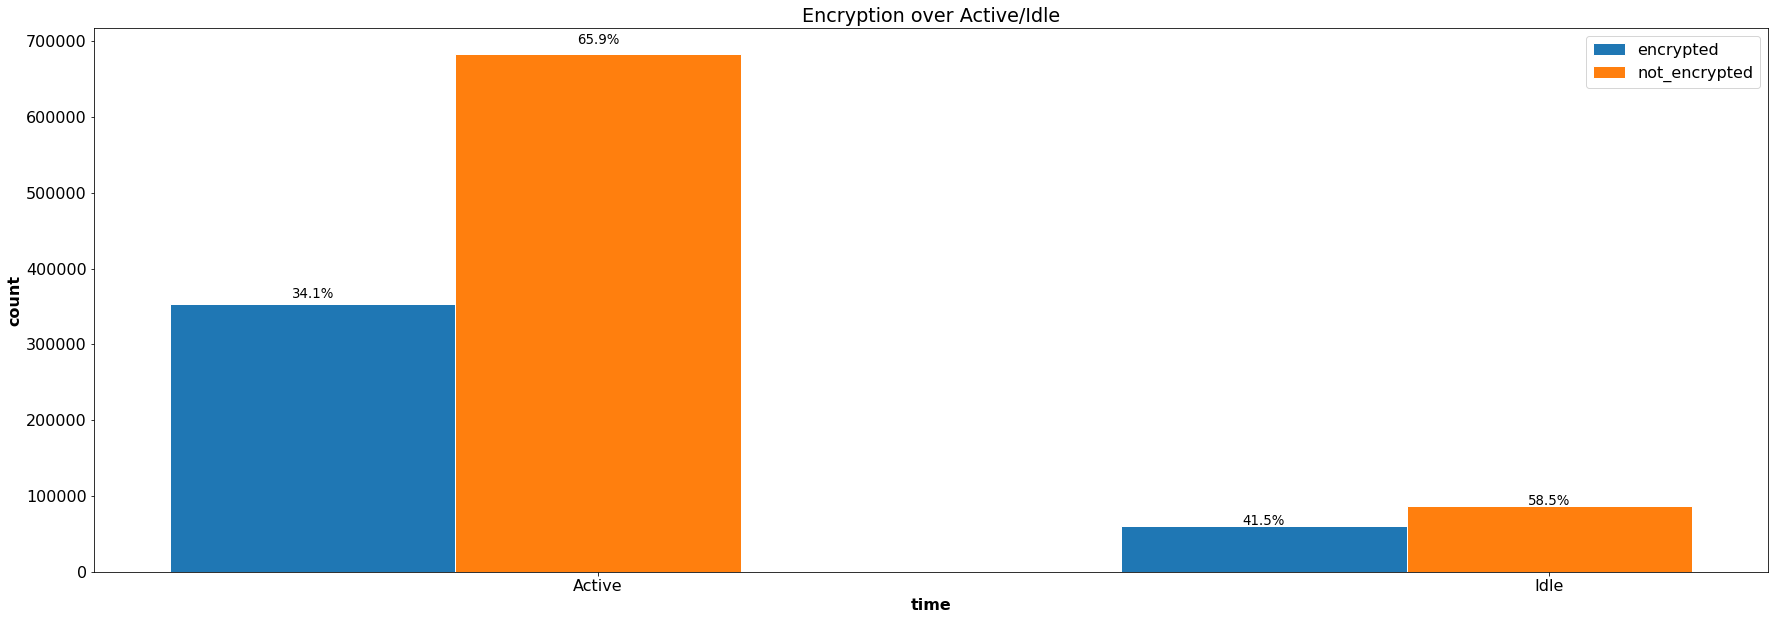

In [46]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.30
 
bars = []
for p in u_protocol_names:
    if p == "encrypted":
        d = temp_df_day[temp_df_day.is_encrypted]
        n = temp_df_night[temp_df_night.is_encrypted]
    else:
        d = temp_df_day[~temp_df_day.is_encrypted]
        n = temp_df_night[~temp_df_night.is_encrypted]
    bars.append([
        d.iloc[0]["count"] if len(d) else 0,
        n.iloc[0]["count"] if len(n) else 0
    ])
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)

sums = list(np.array(bars).sum(axis=0))

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    ax.bar(r, bar, width=barWidth, edgecolor='white', label=v)
    for i, p in enumerate(ax.patches[-len(r):]):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate("{:.1f}%".format(float(height*100/sums[i])), (x + width/2, y + height*1.02), ha='center', fontsize='small')

plt.title("Encryption over Active/Idle")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], ["Active", "Idle"])
 
# # Create legend & Show graphic
plt.legend()
plt.show()


## Application Category 

In [47]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### All Devices

In [48]:
temp = all_df.application_category_name.value_counts()

temp = temp.to_frame().reset_index()


In [49]:
temp = temp[(temp['index']!= 'Unspecified') & (temp["application_category_name"] > 10000)]

Text(0.5, 1.0, 'All Devices')

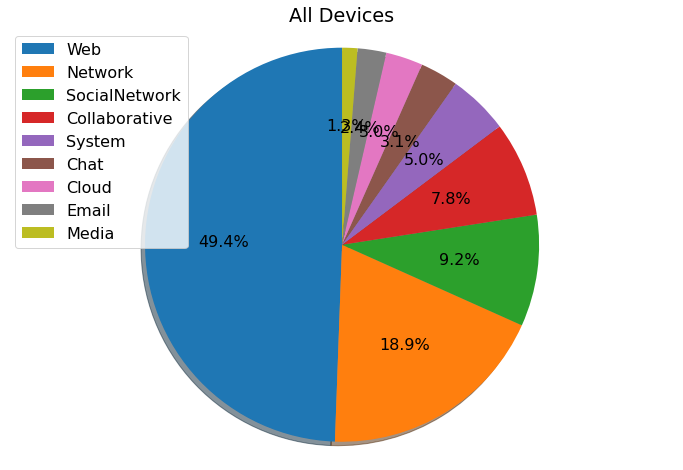

In [50]:
fig1, ax1 = plt.subplots()
ax1.pie(temp.application_category_name.values, labels=' ' * len(temp['index']), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels=temp['index'])
ax1.set_title("All Devices")

### Computer

In [51]:
temp = all_df[all_df["device_type"] == "computer"].application_category_name.value_counts()

temp = temp.to_frame().reset_index()


In [52]:
temp = temp[(temp['index']!= 'Unspecified') & (temp["application_category_name"] > 10000)]

Text(0.5, 1.0, 'Computer')

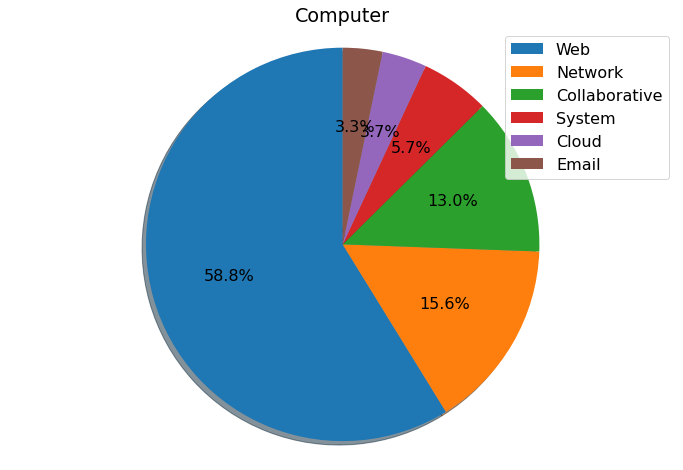

In [53]:
fig1, ax1 = plt.subplots()
ax1.pie(temp.application_category_name.values, labels=' ' * len(temp['index']), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels=temp['index'])
ax1.set_title("Computer")

### Phone

In [54]:
temp = all_df[all_df["device_type"] == "phone"].application_category_name.value_counts()

temp = temp.to_frame().reset_index()


In [55]:
temp = temp[(temp['index']!= 'Unspecified') & (temp["application_category_name"] > 10000)]

Text(0.5, 1.0, 'Phone')

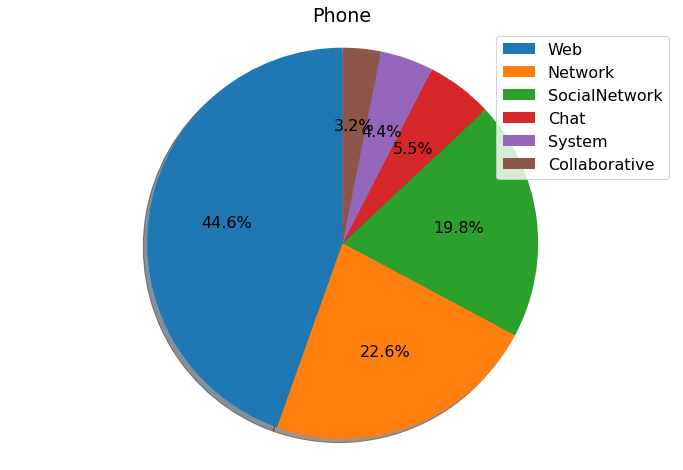

In [56]:
fig1, ax1 = plt.subplots()
ax1.pie(temp.application_category_name.values, labels=' ' * len(temp['index']), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels=temp['index'])
ax1.set_title("Phone")

### Tablet

In [57]:
temp = all_df[all_df["device_type"] == "tablet"].application_category_name.value_counts()

temp = temp.to_frame().reset_index()

In [58]:
temp = temp[(temp['index']!= 'Unspecified') & (temp["application_category_name"])]

Text(0.5, 1.0, 'Tablet')

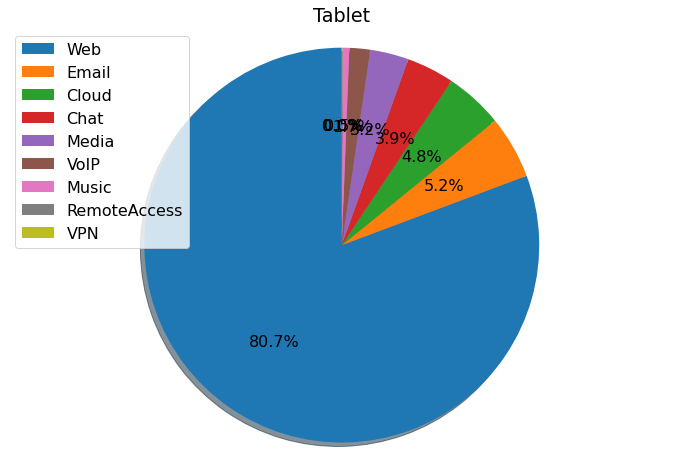

In [59]:
fig1, ax1 = plt.subplots()
ax1.pie(temp.application_category_name.values, labels=' ' * len(temp['index']), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels=temp['index'])
ax1.set_title("Tablet")

### IoT

In [60]:
temp = all_df[all_df["device_type"] == "IoT"].application_category_name.value_counts()

temp = temp.to_frame().reset_index()


In [61]:
temp = temp[(temp['index']!= 'Unspecified') & (temp["application_category_name"])]

Text(0.5, 1.0, 'IoT')

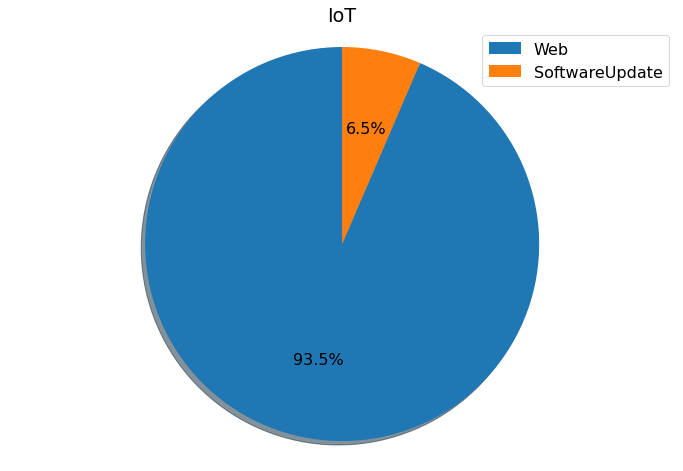

In [62]:
fig1, ax1 = plt.subplots()
ax1.pie(temp.application_category_name.values, labels=' ' * len(temp['index']), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels=temp['index'])
ax1.set_title("IoT")

## Ad Analysis

### Day Night Aggreagation

In [63]:
temp_df = all_df.groupby(["is_night", "is_ad"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [64]:
u_protocol_names = ["Ad", "not Ad"]

temp_df_day = temp_df[~temp_df.is_night].copy()
temp_df_night = temp_df[temp_df.is_night].copy()

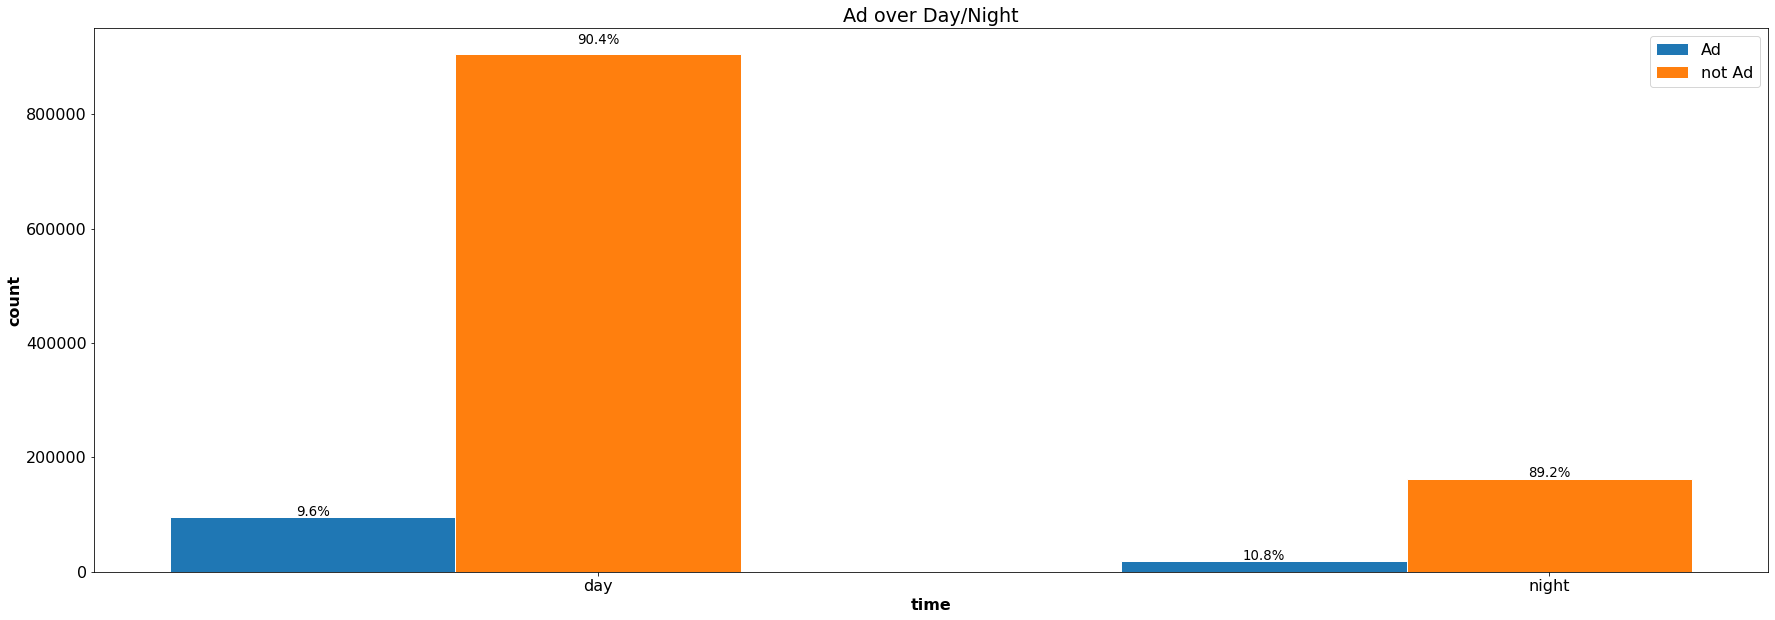

In [65]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.30
 
bars = []
for p in u_protocol_names:
    if p == "Ad":
        d = temp_df_day[temp_df_day.is_ad]
        n = temp_df_night[temp_df_night.is_ad]
    else:
        d = temp_df_day[~temp_df_day.is_ad]
        n = temp_df_night[~temp_df_night.is_ad]
    bars.append([
        d.iloc[0]["count"] if len(d) else 0,
        n.iloc[0]["count"] if len(n) else 0
    ])
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)

sums = list(np.array(bars).sum(axis=0))

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    ax.bar(r, bar, width=barWidth, edgecolor='white', label=v)
    for i, p in enumerate(ax.patches[-len(r):]):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate("{:.1f}%".format(float(height*100/sums[i])), (x + width/2, y + height*1.02), ha='center', fontsize='small')

plt.title("Ad over Day/Night")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], ["day", "night"])
 
# # Create legend & Show graphic
plt.legend()
plt.show()


## Device Type Aggreagation

In [66]:
temp_df = all_df.groupby(["device_type", "is_ad"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()


temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [67]:
u_protocol_names = ["Ad", "not Ad"]

temp_dfs = [temp_df[temp_df.device_type == dt].copy() for dt in all_devices]

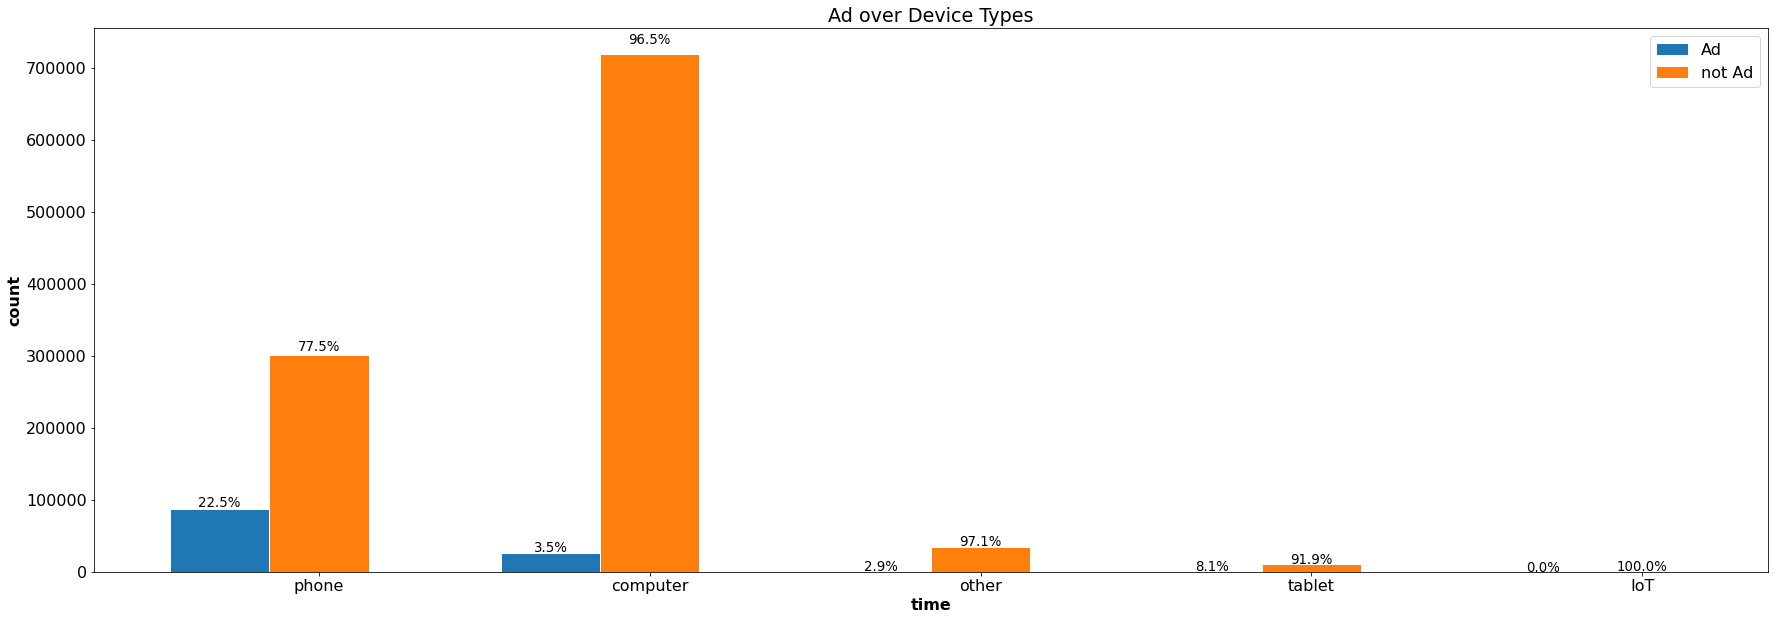

In [68]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.30
 
bars = []
for p in u_protocol_names:
    tl = []
    for t in temp_dfs:
        d = t[~t.is_ad]
        if p == "Ad":
            d = t[t.is_ad]
        tl.append(d.iloc[0]["count"] if len(d) else 0)
    bars.append(tl)
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)

sums = list(np.array(bars).sum(axis=0))

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    ax.bar(r, bar, width=barWidth, edgecolor='white', label=v)
    for i, p in enumerate(ax.patches[-len(r):]):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate("{:.1f}%".format(float(height*100/sums[i])), (x + width/2, y + height*1.02), ha='center', fontsize='small')

plt.title("Ad over Device Types")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], all_devices)
 
# # Create legend & Show graphic
plt.legend()
plt.show()


### Idle

In [69]:
temp_df = all_df.groupby(["is_idle", "is_ad"])["id"].count().to_frame()
temp_df.columns = ["count"]
temp_df = temp_df.reset_index()

temp_df = temp_df[temp_df["count"] > 250]
# temp_df["count"] = temp_df["count"].apply(np.log1p)

In [70]:
u_protocol_names = ["Ad", "not Ad"]

temp_df_day = temp_df[~temp_df.is_idle].copy()
temp_df_night = temp_df[temp_df.is_idle].copy()

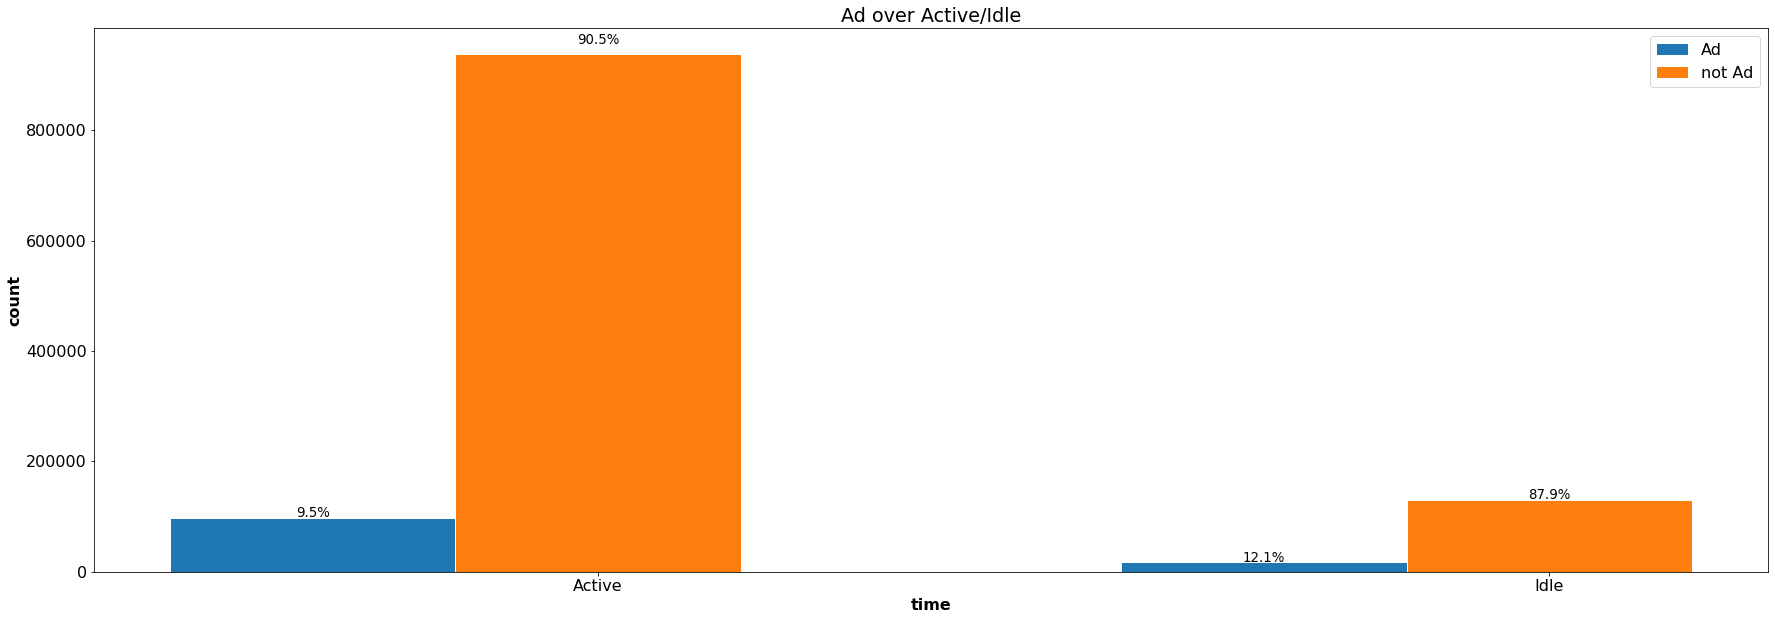

In [71]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.30
 
bars = []
for p in u_protocol_names:
    if p == "Ad":
        d = temp_df_day[temp_df_day.is_ad]
        n = temp_df_night[temp_df_night.is_ad]
    else:
        d = temp_df_day[~temp_df_day.is_ad]
        n = temp_df_night[~temp_df_night.is_ad]
    bars.append([
        d.iloc[0]["count"] if len(d) else 0,
        n.iloc[0]["count"] if len(n) else 0
    ])
    
rs = [np.arange(len(bars[0]))]
for i in range(1, len(bars)):
    rs.append([x + barWidth for x in rs[i - 1]])

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)

sums = list(np.array(bars).sum(axis=0))

# # Make the plot
for r, bar, v in zip(rs, bars, u_protocol_names):
    ax.bar(r, bar, width=barWidth, edgecolor='white', label=v)
    for i, p in enumerate(ax.patches[-len(r):]):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate("{:.1f}%".format(float(height*100/sums[i])), (x + width/2, y + height*1.02), ha='center', fontsize='small')

plt.title("Ad over Active/Idle")
# # Add xticks on the middle of the group bars
plt.xlabel('time', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[1]))], ["Active", "Idle"])
 
# # Create legend & Show graphic
plt.legend()
plt.show()
